In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

#DataSet Split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
#Gradient Boosting
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error, r2_score
#Naive Linear Regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
#Trigonometric features
from sklearn.preprocessing import FunctionTransformer
#Periodic Spline Features
from sklearn.preprocessing import SplineTransformer
#Pairwise interactions with splines and polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
#Non-Linear feature interactions with kernels
from sklearn.kernel_approximation import Nystroem

from sklearn.linear_model import LinearRegression

from numpy.fft import rfft, irfft, rfftfreq
from scipy import signal, fftpack

from statsmodels.tsa.seasonal import seasonal_decompose

data = pd.read_csv("../data/daily_sunspots_time_series_1850-01_2024-05.csv", parse_dates=['date'])
data.set_index('date', inplace = True)
data = data.drop(['date_frac', 'std', 'nobs'], axis = 1)
import time

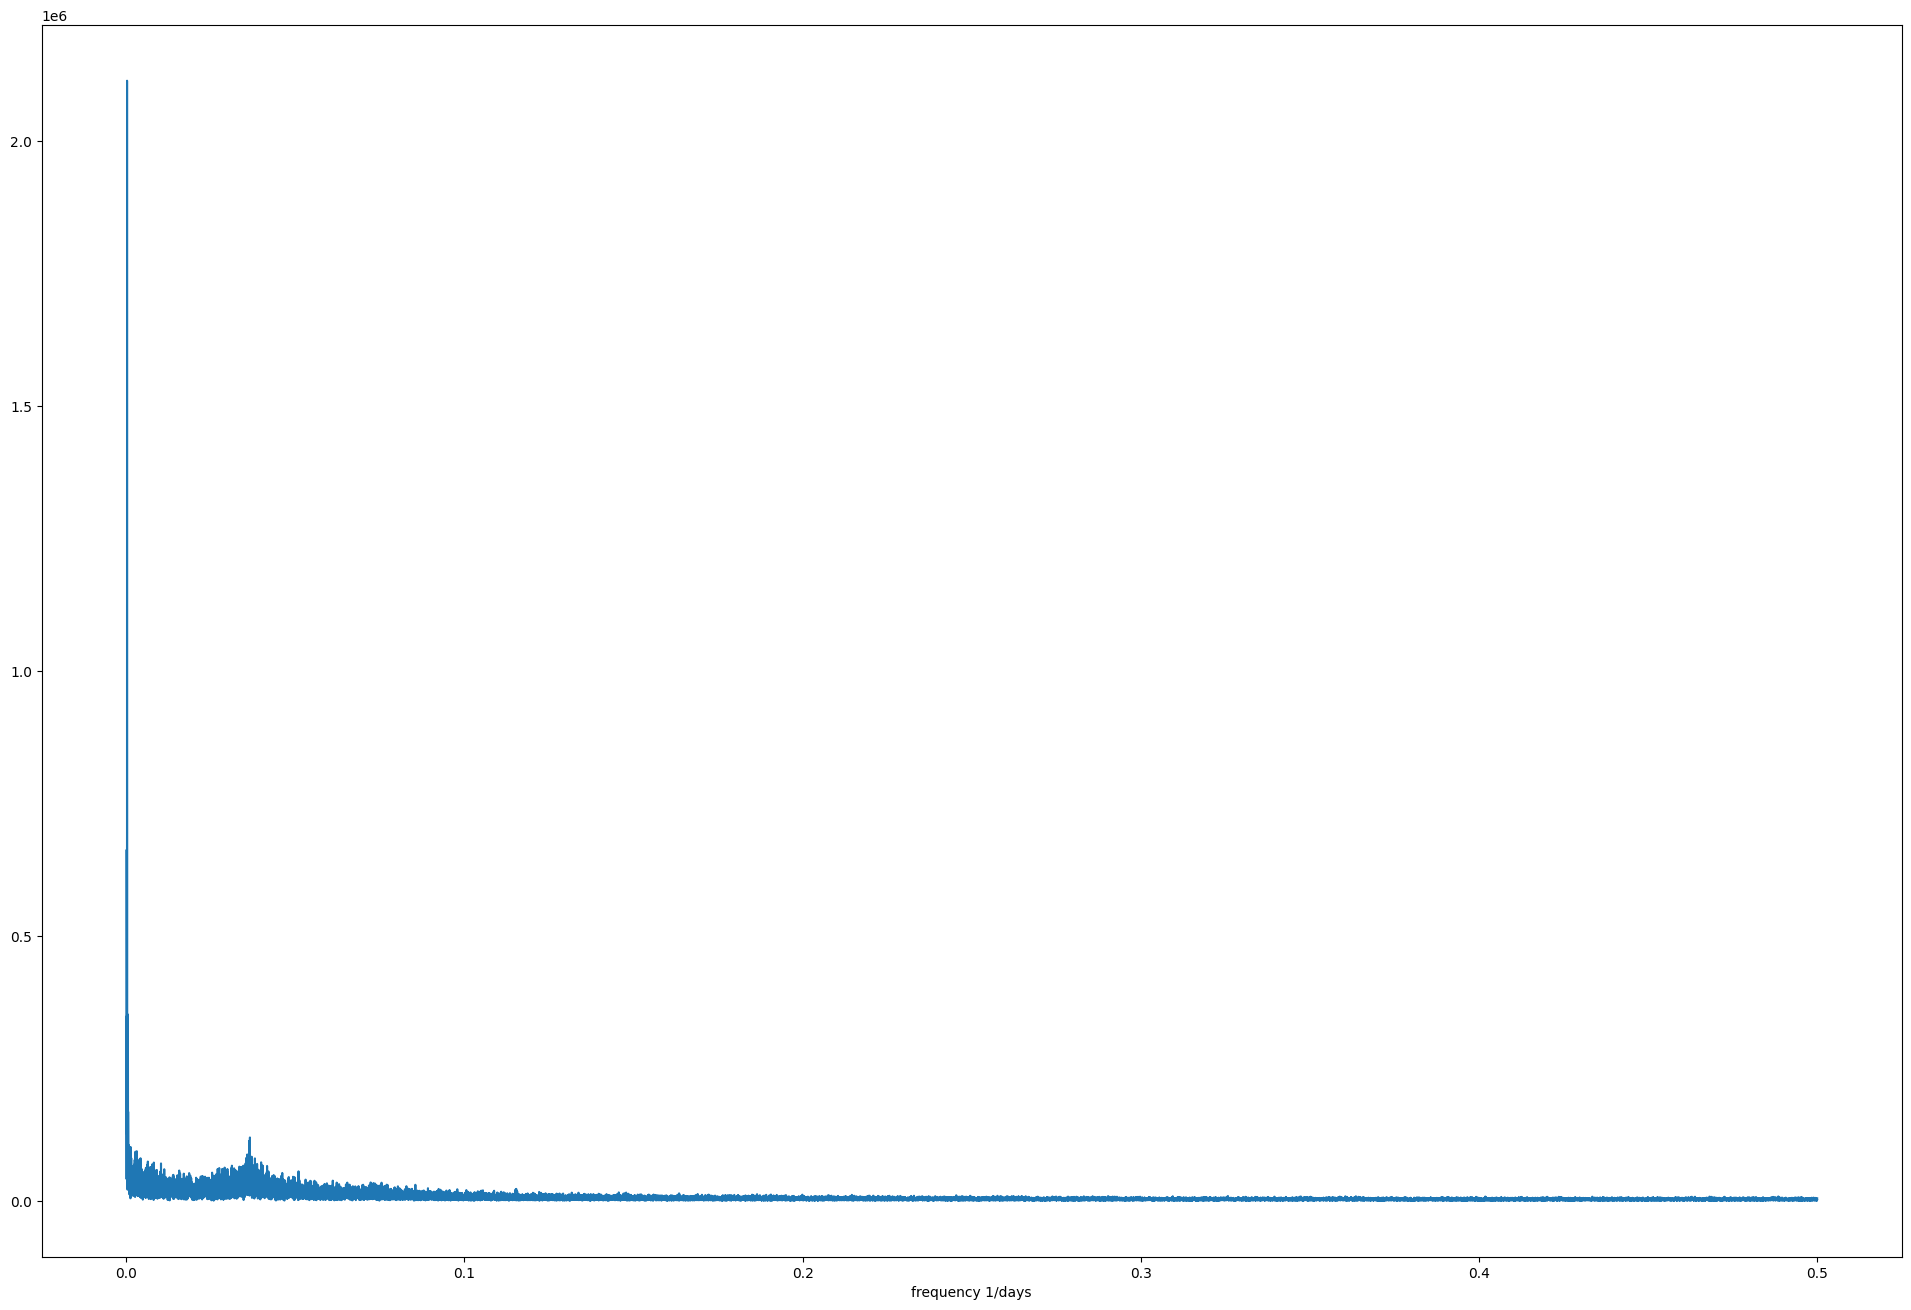

In [2]:
n_obs = len(data.counts)
sunspot_ft = np.abs(rfft(data.counts))
sunspot_freq = rfftfreq(n_obs)
plt.figure(figsize=(24,16))
plt.plot(sunspot_freq[1:], sunspot_ft[1:])
plt.xlabel('frequency 1/days')
plt.show()

In [3]:
sp = pd.DataFrame({'freqency [1/day]':sunspot_freq[1: ], 'y':sunspot_ft[1: ]})
sp['period [days]'] = (1/sp['freqency [1/day]'])

sp_sort = sp.sort_values(by=['y'], ascending=False)
sp_sort.query('y>100000')

,freqency [1/day],y,period [days]
15,0.000251,2.114640e+06,3979.562500
16,0.000267,8.967146e+05,3745.470588
17,0.000283,6.639532e+05,3537.388889
0,0.000016,6.611474e+05,63673.000000
14,0.000236,5.757567e+05,4244.866667
1,0.000031,5.124960e+05,31836.500000
3,0.000063,4.733001e+05,15918.250000
19,0.000314,3.959381e+05,3183.650000
31,0.000503,3.515802e+05,1989.781250
7,0.000126,3.483085e+05,7959.125000


In [30]:
T1 = int(1/sunspot_freq[1:][np.argmax(sunspot_ft[1:])])
T2 = sp_sort['period [days]'][16]
T3 = sp_sort['period [days]'][17]
T4 = sp_sort['period [days]'][0]
T5 = sp_sort['period [days]'][14]

In [7]:
def qcd_variance(series, window = T1):
    """This function returns the quartile coefficient of 
        disopersion of the rolling variance of a series in a given window range
    """
    #rolling variance for a given window
    variances = series.rolling(window).var().dropna()
    #first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    #third quatile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    #quartile coefficient of dispersion
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    print(f"quartile coefficient of dispersion: {qcd}")

qcd_variance(data.counts)

quartile coefficient of dispersion: 0.349389


Is not an additive model!

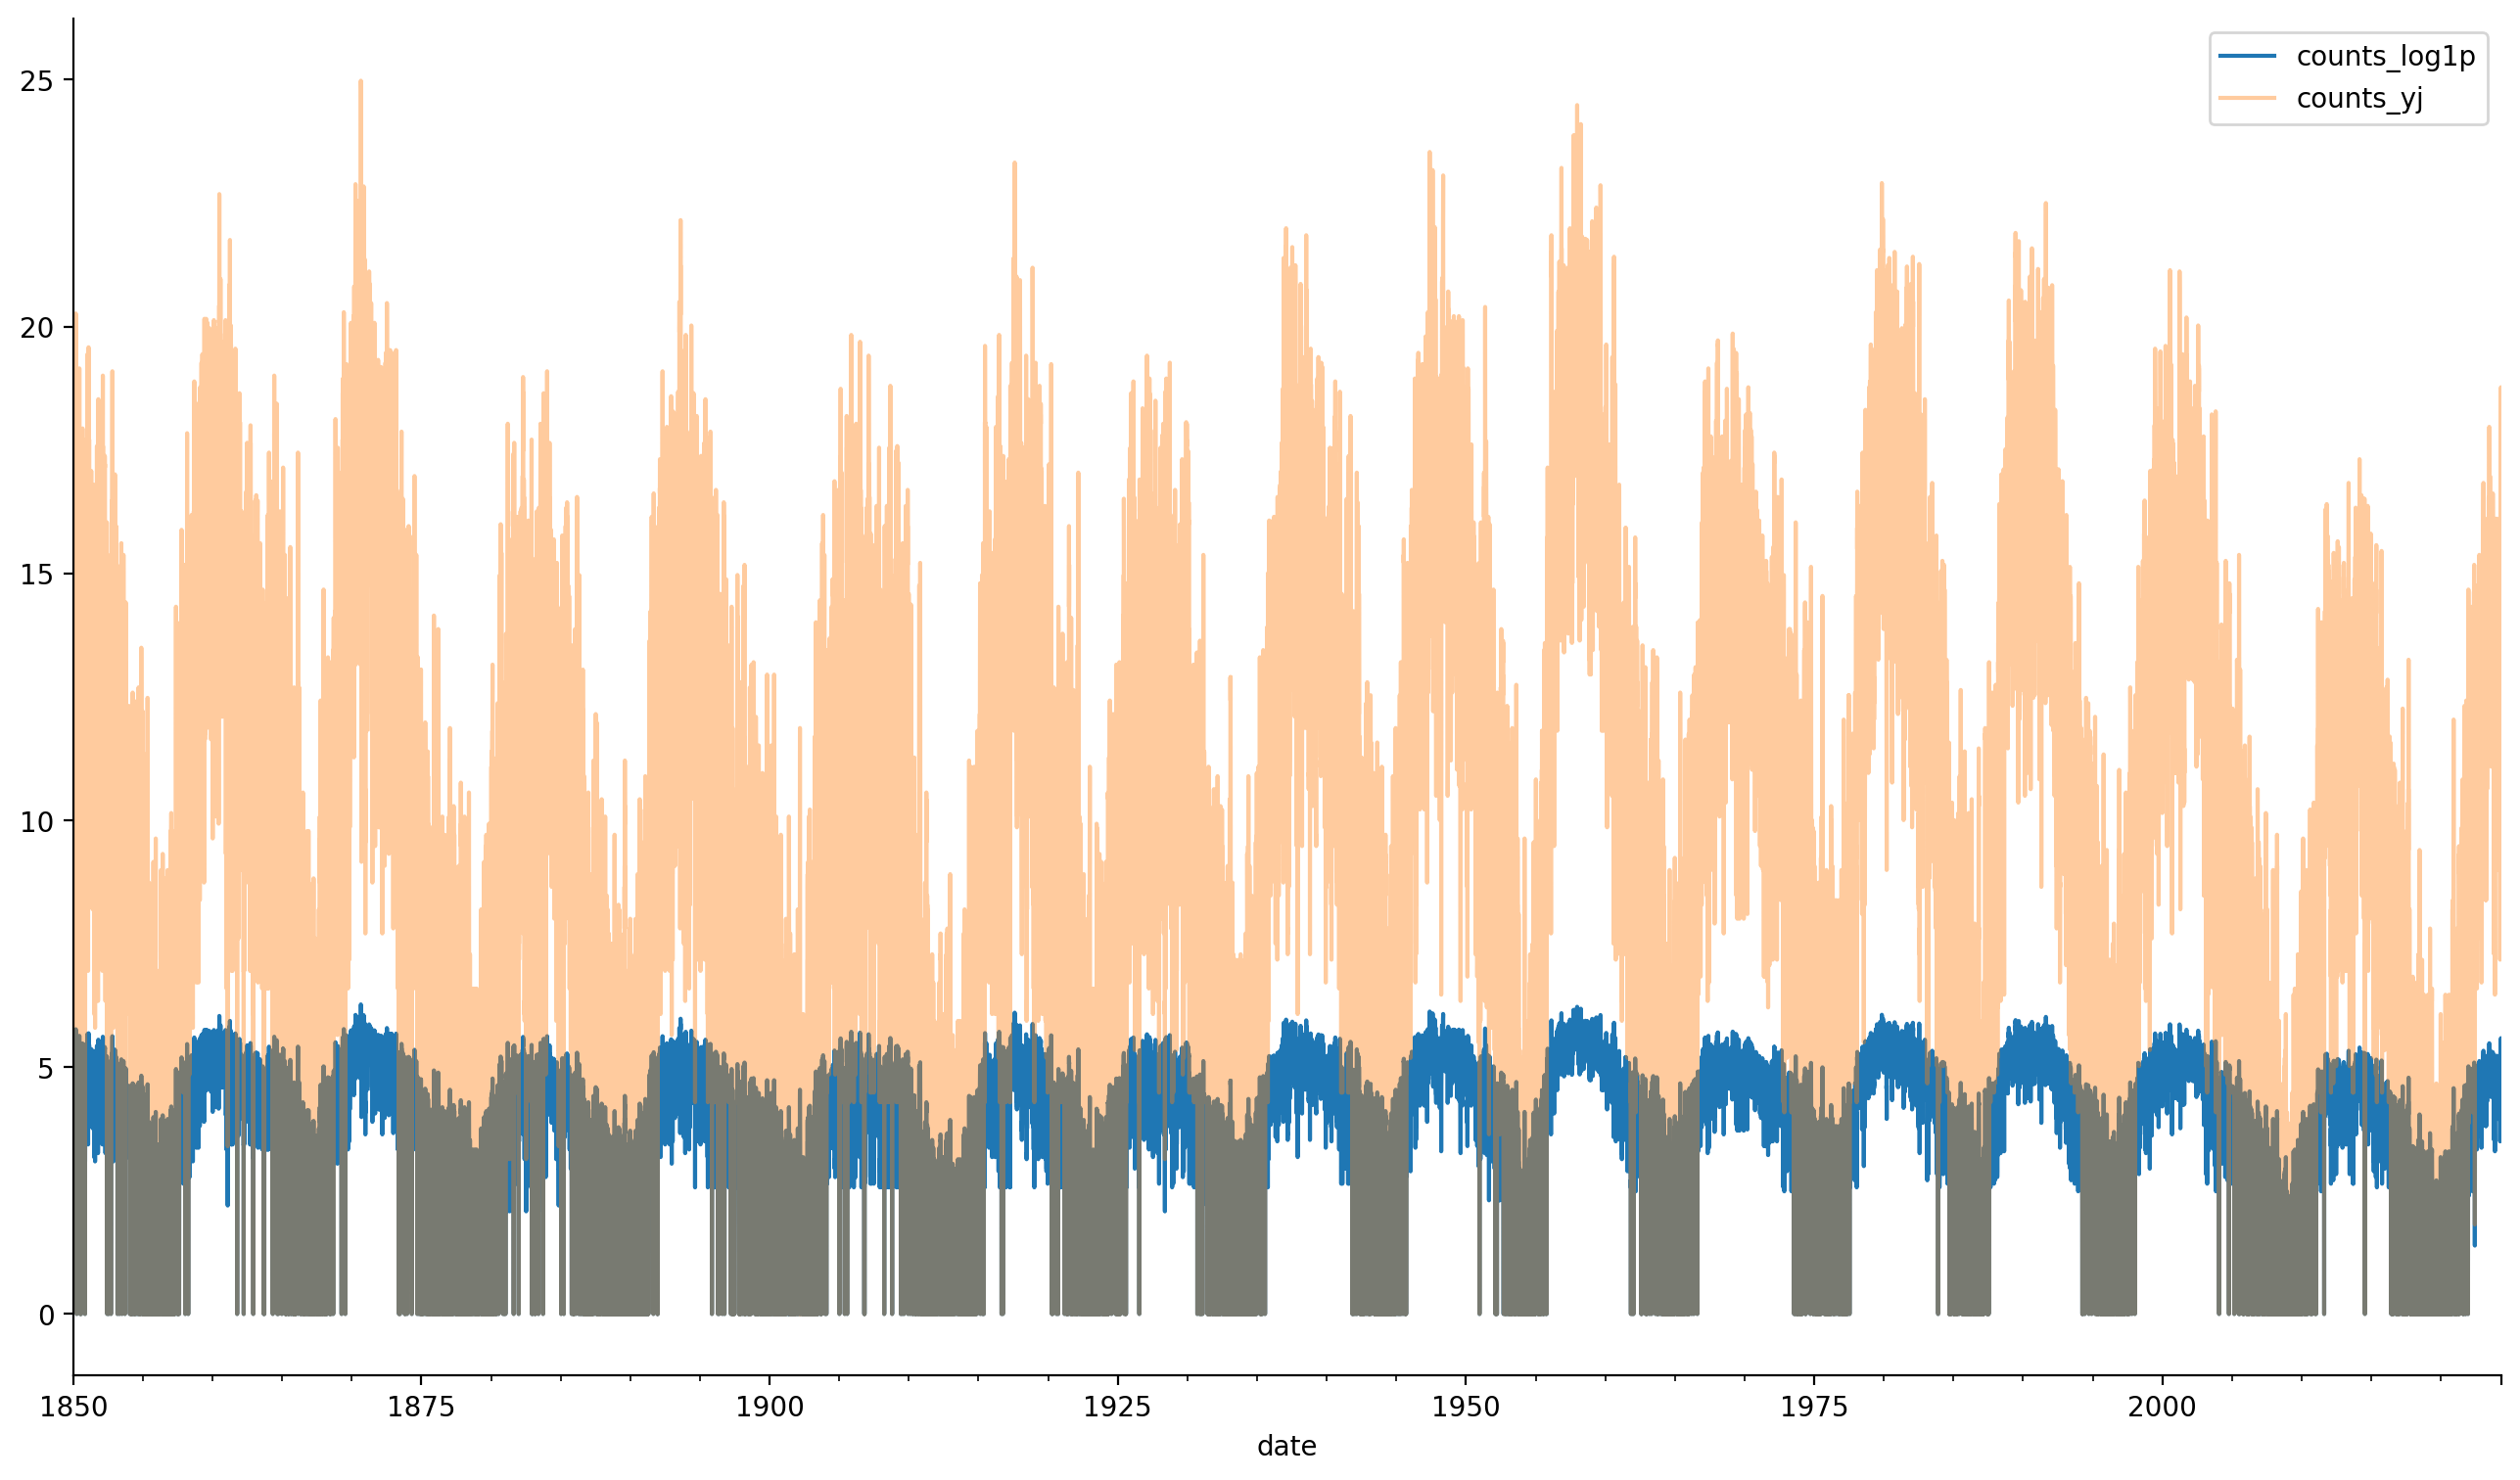

In [11]:
# Log transform
from scipy import stats

data['counts_yj'], _ = stats.yeojohnson(data.counts)
data['counts_log1p'] = np.log1p(data.counts)
mpl.rc('figure',figsize=(16,9),dpi=200)
data['counts_log1p'].plot(legend=True)
data['counts_yj'].plot(legend = True, alpha = 0.4)
sns.despine()

In [21]:
# New Index for the year in the solarcycle
new_index = np.arange(data.shape[0])% T1 // 365
data['year_sc'] = new_index

test_width = int(0.1*len(data))
train = data.iloc[:-test_width]
test = data.iloc[-test_width:]



train['timestep'] = list(range(train.shape[0]))
test['timestep'] = list(
    range(train.shape[0], train.shape[0]+test.shape[0])
)

In [22]:
from sklearn.preprocessing import FunctionTransformer
def sin_feature(period):
    return FunctionTransformer(lambda t: np.sin((2*np.pi/period)*t))
                               
def cos_feature(period):
    return FunctionTransformer(lambda t: np.cos((2*np.pi/period)*t))

In [23]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits = 5,
    gap = 0,
    max_train_size = None,
    test_size = None
)

# We can inspect the 5 split to see how they look like
X_train_cv = train[['timestep', 'day']]
Y_train_cv = train['counts_log1p']
#Y_train_cv = train['counts_yj']
all_splits = list(ts_cv.split(X_train_cv, Y_train_cv))

In [43]:
param_grid = {'transformer__poly__degree': [1,2,3,4,5,6]}

# Feature transformation
cyclic_cossin_transformer = ColumnTransformer(
    transformers = [
        ("sin1", sin_feature(T1), ['timestep']),
        ("cos1", cos_feature(T1), ['timestep']),
        ("sin2", sin_feature(T2), ['timestep']),
        ("cos2", cos_feature(T2), ['timestep']),
        ("sin3", sin_feature(T3), ['timestep']),
        ("cos3", cos_feature(T3), ['timestep']),
        #("sin4", sin_feature(T4), ['timestep']),
        #("cos4", cos_feature(T4), ['timestep']),
        #("sin5", sin_feature(T5), ['timestep']),
        #("cos5", cos_feature(T5), ['timestep']),
        ('poly', PolynomialFeatures(),['timestep'])#,
        #('ohe', OneHotEncoder(drop='first'), ['day'])
        ]
    )

estimator_trigonometric = Pipeline(steps = [
    ('transformer', cyclic_cossin_transformer),
    ('LR', LinearRegression())

])

gscv = GridSearchCV(
    estimator = estimator_trigonometric,
    param_grid = param_grid,
    scoring = 'r2',
    cv = ts_cv,
    n_jobs = -1
)

# initial time
ti = time.time()

# grid-search cross-validation
gscv.fit(X_train_cv,Y_train_cv)

# final time 
tf = time.time()

# time taken
print(f"time taken: {round(tf-ti,2)} sec")

time taken: 0.19 sec


In [44]:
column_list = ['param_transformer__poly__degree',
               'mean_test_score',
               'std_test_score',
               'rank_test_score'
              ]
result_df = pd.DataFrame(gscv.cv_results_)[column_list]

result_df.rename(
    columns=lambda name: name.split('__')[-1],inplace=True
)
result_df

,degree,mean_test_score,std_test_score,rank_test_score
0,1,-0.499780,0.528920,1
1,2,-2.542315,4.371123,2
2,3,-18.620547,33.803852,3
3,4,-34.772711,57.123364,4
4,5,-4654.650194,7916.705479,5
5,6,-252046.138199,496207.387843,6


In [45]:
model_cv = gscv.best_estimator_
model_cv.fit(X_train_cv, Y_train_cv)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('sin1',
                                                  FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x3326ae160>),
                                                  ['timestep']),
                                                 ('cos1',
                                                  FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x3326ae200>),
                                                  ['timestep']),
                                                 ('sin2',
                                                  FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x3326ae2a0>...
                                                  FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x3326ae0c0>),
                                                  ['timestep']),
                                                 ('sin3',
                                                  FunctionTransformer(func=<function sin_feature.<locals>.<lambda> at 0x3326ae3e0>),
                                                  ['timestep']),
                                                 ('cos3',
                                                  FunctionTransformer(func=<function cos_feature.<locals>.<lambda> at 0x3326aef20>),
                                                  ['timestep']),
                                                 ('poly',
                                                  PolynomialFeatures(degree=1),
                                                  ['timestep'])])),
                ('LR', LinearRegression())])

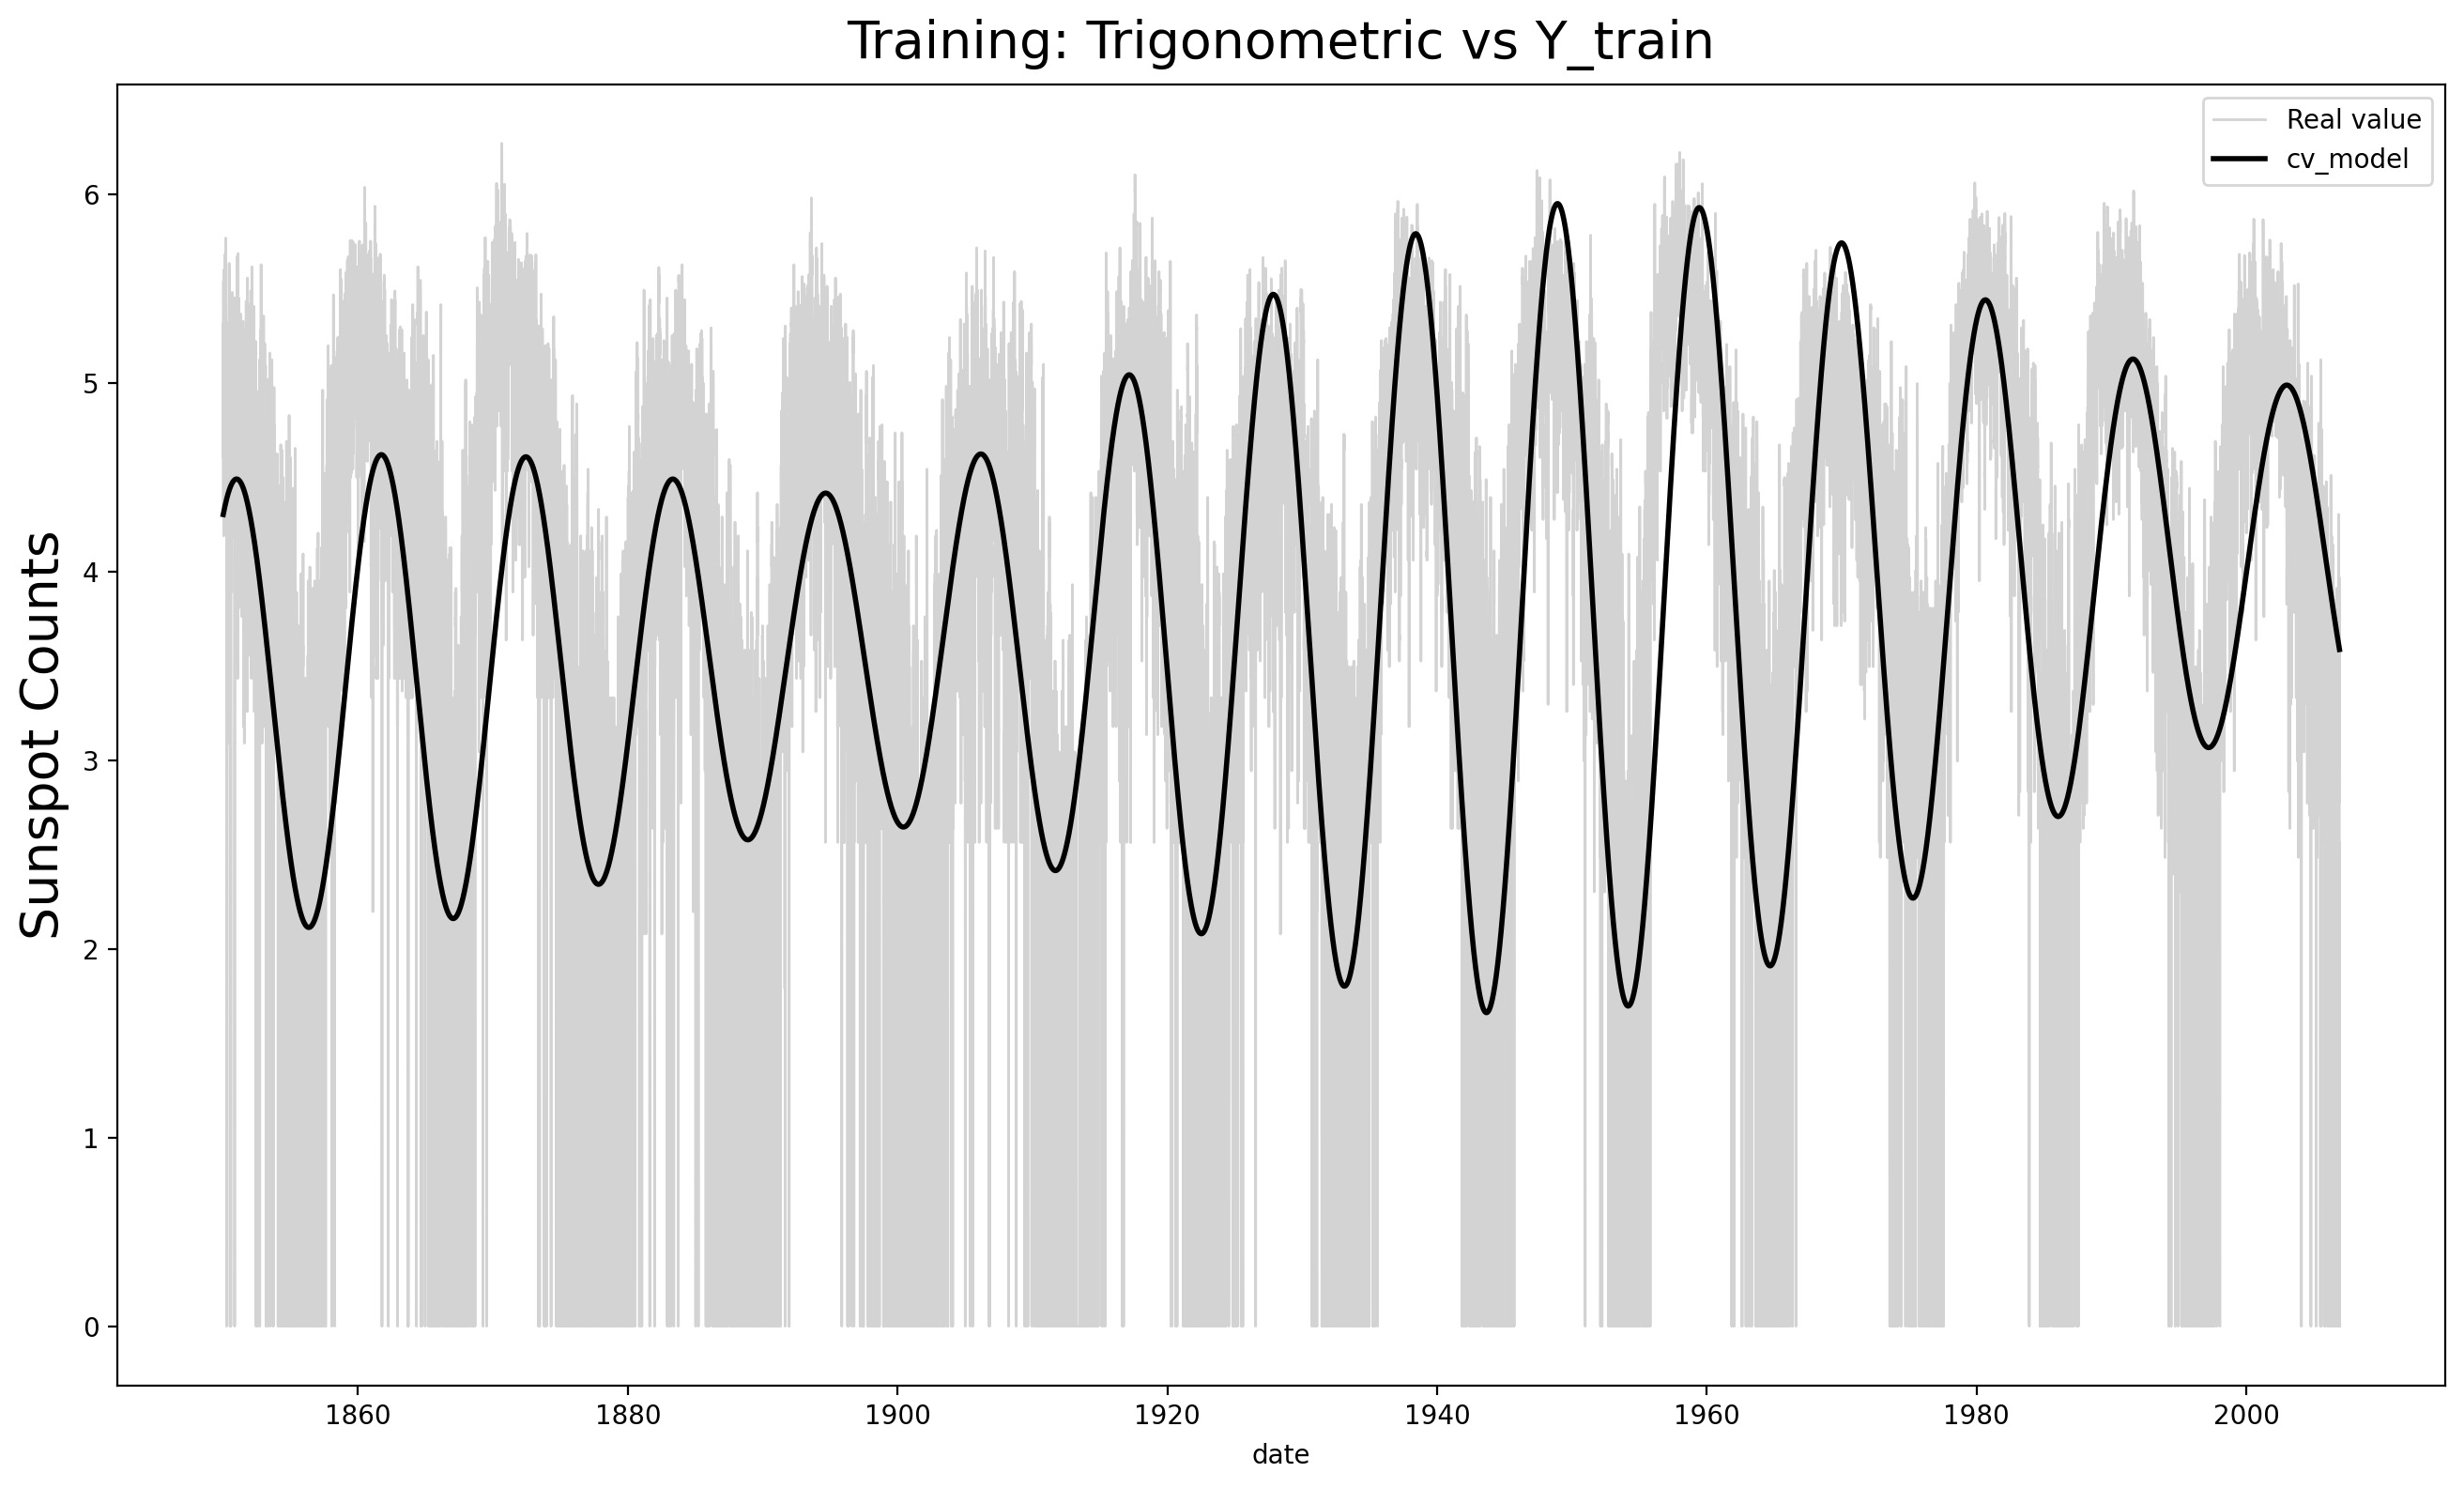

In [46]:
train['cv_baseline'] = model_cv.predict(X_train_cv)
fig = plt.figure(figsize=(16,9))
plt.plot(train['counts_log1p'], linewidth=1, color = 'lightgrey')
plt.plot(train['cv_baseline'], linewidth=2, color = 'black')
plt.xlabel('date',fontsize=10, labelpad=5)
plt.ylabel('Sunspot Counts',fontsize=20, labelpad=5)
plt.legend(['Real value','cv_model'], prop={'size': 10})
plt.title('Training: Trigonometric vs Y_train',fontsize=20, pad=10)                  
plt.show()

In [47]:
def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

In [53]:
num_fourier_terms = 4
n = len(data)
fourier_terms = create_fourier_terms(len(data), T1, num_fourier_terms)
from pmdarima import auto_arima

model = auto_arima(data['counts_log1p'],exogenous=fourier_terms[:n], seasonal=True, suppress_warnings=True)
model.fit(data['counts_log1p'], exogenous=fourier_terms[:n])


KeyboardInterrupt: 